# Day 3: Transformer Architecture for Time Series Prediction

## Week 15: Attention & Transformers in Finance

---

## Learning Objectives

1. **Understand the full Transformer architecture** - encoder-decoder structure
2. **Implement positional encoding** for sequence position information
3. **Build encoder and decoder blocks** with multi-head attention
4. **Apply Transformers to financial time series prediction**

---

## Why Transformers for Finance?

- **Parallel processing** - unlike RNNs, can process entire sequences at once
- **Long-range dependencies** - attention spans entire sequence without decay
- **Scalability** - efficiently handles large datasets
- **State-of-the-art performance** - dominates NLP and increasingly time series tasks

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---

## Part 1: Full Transformer Architecture Overview

### The Original Transformer ("Attention Is All You Need", 2017)

```
┌─────────────────────────────────────────────────────────────┐
│                    TRANSFORMER ARCHITECTURE                  │
├─────────────────────────────────────────────────────────────┤
│                                                              │
│   INPUT SEQUENCE          OUTPUT SEQUENCE (shifted right)    │
│         │                           │                        │
│         ▼                           ▼                        │
│  ┌──────────────┐           ┌──────────────┐                 │
│  │   Input      │           │   Output     │                 │
│  │  Embedding   │           │  Embedding   │                 │
│  └──────┬───────┘           └──────┬───────┘                 │
│         │                           │                        │
│         ▼                           ▼                        │
│  ┌──────────────┐           ┌──────────────┐                 │
│  │  Positional  │           │  Positional  │                 │
│  │   Encoding   │           │   Encoding   │                 │
│  └──────┬───────┘           └──────┬───────┘                 │
│         │                           │                        │
│         ▼                           ▼                        │
│  ┌──────────────┐           ┌──────────────┐                 │
│  │              │           │   Masked     │                 │
│  │   ENCODER    │──────────▶│   DECODER    │                 │
│  │   (N×)       │           │   (N×)       │                 │
│  │              │           │              │                 │
│  └──────────────┘           └──────┬───────┘                 │
│                                     │                        │
│                                     ▼                        │
│                             ┌──────────────┐                 │
│                             │    Linear    │                 │
│                             │   + Softmax  │                 │
│                             └──────┬───────┘                 │
│                                     │                        │
│                                     ▼                        │
│                              OUTPUT PROBABILITIES            │
│                                                              │
└─────────────────────────────────────────────────────────────┘
```

### Key Components:

| Component | Purpose |
|-----------|----------|
| **Embedding** | Convert tokens to dense vectors |
| **Positional Encoding** | Add position information to embeddings |
| **Encoder** | Process input sequence, build representations |
| **Decoder** | Generate output using encoder output + masked self-attention |
| **Multi-Head Attention** | Learn multiple attention patterns simultaneously |

---

## Part 2: Positional Encoding

Since Transformers process sequences in parallel (no recurrence), we need to explicitly encode position information.

### Sinusoidal Positional Encoding

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

Where:
- $pos$ = position in sequence
- $i$ = dimension index
- $d_{model}$ = embedding dimension

### Why Sinusoidal?
- **Deterministic** - no learned parameters needed
- **Relative positions** - $PE_{pos+k}$ can be represented as linear function of $PE_{pos}$
- **Generalizes** - works for sequences longer than training data

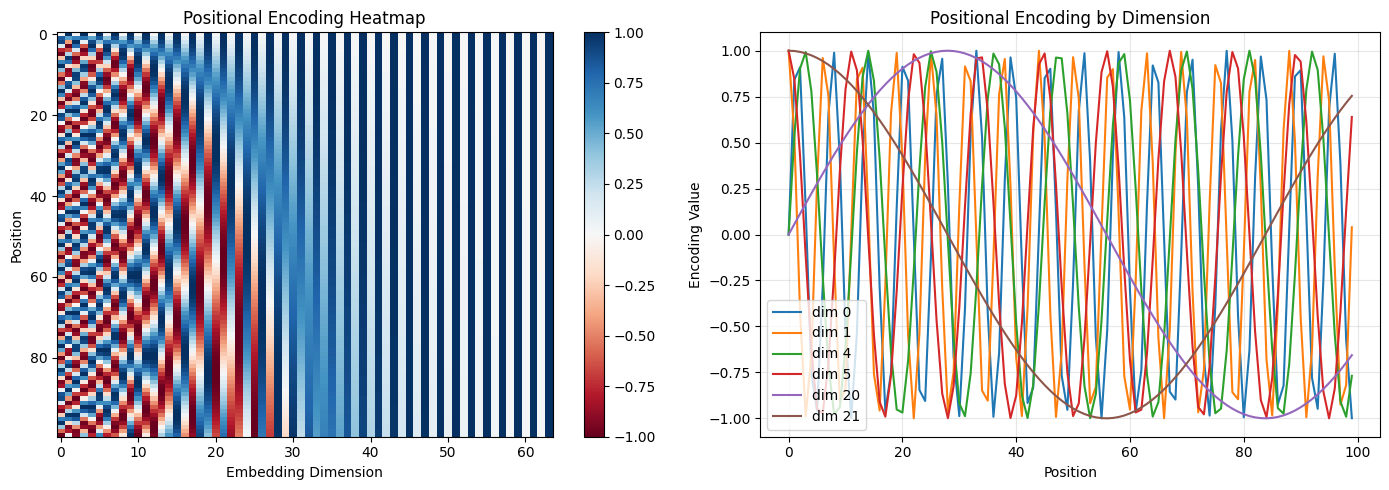

In [2]:
class PositionalEncoding(nn.Module):
    """
    Sinusoidal Positional Encoding
    Adds position information to input embeddings
    """
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Compute division term
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        
        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension: (max_len, d_model) -> (1, max_len, d_model)
        pe = pe.unsqueeze(0)
        
        # Register as buffer (not a parameter, but should be saved)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# Visualize positional encoding
def visualize_positional_encoding(d_model=64, max_len=100):
    """Visualize the positional encoding patterns"""
    pe = PositionalEncoding(d_model, max_len, dropout=0.0)
    encoding = pe.pe.squeeze(0).numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Heatmap of positional encoding
    im = axes[0].imshow(encoding, cmap='RdBu', aspect='auto')
    axes[0].set_xlabel('Embedding Dimension')
    axes[0].set_ylabel('Position')
    axes[0].set_title('Positional Encoding Heatmap')
    plt.colorbar(im, ax=axes[0])
    
    # Plot specific dimensions
    positions = np.arange(max_len)
    for dim in [0, 1, 4, 5, 20, 21]:
        axes[1].plot(positions, encoding[:, dim], label=f'dim {dim}')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Encoding Value')
    axes[1].set_title('Positional Encoding by Dimension')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_positional_encoding()

---

## Part 3: Encoder Block

### Encoder Structure

```
┌─────────────────────────────────────┐
│           ENCODER BLOCK              │
├─────────────────────────────────────┤
│                                      │
│         Input (x)                    │
│            │                         │
│            ▼                         │
│   ┌────────────────────┐             │
│   │  Multi-Head        │             │
│   │  Self-Attention    │◀─┐          │
│   └────────┬───────────┘  │          │
│            │              │ Residual │
│            ▼              │          │
│   ┌────────────────────┐  │          │
│   │  Add & LayerNorm   │──┘          │
│   └────────┬───────────┘             │
│            │                         │
│            ▼                         │
│   ┌────────────────────┐             │
│   │  Feed Forward      │◀─┐          │
│   │  Network           │  │          │
│   └────────┬───────────┘  │ Residual │
│            │              │          │
│            ▼              │          │
│   ┌────────────────────┐  │          │
│   │  Add & LayerNorm   │──┘          │
│   └────────┬───────────┘             │
│            │                         │
│            ▼                         │
│         Output                       │
│                                      │
└─────────────────────────────────────┘
```

In [3]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism
    Allows model to attend to information from different representation subspaces
    """
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # Dimension per head
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
    
    def forward(self, query, key, value, mask=None):
        """
        Args:
            query: (batch_size, seq_len, d_model)
            key: (batch_size, seq_len, d_model)
            value: (batch_size, seq_len, d_model)
            mask: Optional attention mask
        """
        batch_size = query.size(0)
        
        # Linear projections and reshape for multi-head
        # (batch_size, seq_len, d_model) -> (batch_size, n_heads, seq_len, d_k)
        Q = self.W_q(query).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        # (batch_size, n_heads, seq_len, seq_len)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        
        # Softmax and dropout
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        # (batch_size, n_heads, seq_len, d_k)
        context = torch.matmul(attention_weights, V)
        
        # Concatenate heads and project
        # (batch_size, seq_len, d_model)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)
        
        return output, attention_weights


class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network
    FFN(x) = max(0, xW1 + b1)W2 + b2
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()  # GELU often used in modern transformers
    
    def forward(self, x):
        return self.linear2(self.dropout(self.activation(self.linear1(x))))


class EncoderBlock(nn.Module):
    """
    Single Encoder Block with Multi-Head Attention and Feed-Forward
    """
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        # Multi-head self-attention
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        
        # Feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Self-attention with residual connection and layer norm
        attn_output, attn_weights = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x, attn_weights


# Test encoder block
print("Testing Encoder Block:")
encoder_block = EncoderBlock(d_model=64, n_heads=8, d_ff=256)
test_input = torch.randn(2, 10, 64)  # (batch_size, seq_len, d_model)
output, weights = encoder_block(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")

Testing Encoder Block:
Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
Attention weights shape: torch.Size([2, 8, 10, 10])


---

## Part 4: Decoder Block

### Decoder Structure

```
┌─────────────────────────────────────┐
│           DECODER BLOCK              │
├─────────────────────────────────────┤
│                                      │
│    Target Input (y)   Encoder Output │
│         │                  │         │
│         ▼                  │         │
│  ┌────────────────────┐    │         │
│  │  MASKED Multi-Head │    │         │
│  │  Self-Attention    │    │         │
│  └────────┬───────────┘    │         │
│           │                │         │
│           ▼                │         │
│  ┌────────────────────┐    │         │
│  │  Add & LayerNorm   │    │         │
│  └────────┬───────────┘    │         │
│           │                │         │
│           ▼                ▼         │
│  ┌────────────────────────────┐      │
│  │  Cross-Attention           │      │
│  │  (Q from decoder,          │      │
│  │   K,V from encoder)        │      │
│  └────────┬───────────────────┘      │
│           │                          │
│           ▼                          │
│  ┌────────────────────┐              │
│  │  Add & LayerNorm   │              │
│  └────────┬───────────┘              │
│           │                          │
│           ▼                          │
│  ┌────────────────────┐              │
│  │  Feed Forward      │              │
│  └────────┬───────────┘              │
│           │                          │
│           ▼                          │
│  ┌────────────────────┐              │
│  │  Add & LayerNorm   │              │
│  └────────┬───────────┘              │
│           │                          │
│           ▼                          │
│        Output                        │
│                                      │
└─────────────────────────────────────┘
```

### Key Difference: Masked Self-Attention
- Prevents positions from attending to subsequent positions
- Ensures autoregressive property during training

Causal Mask for sequence length 8:


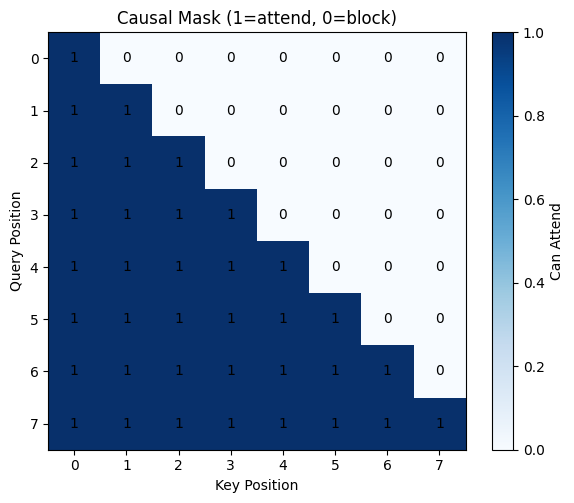

In [4]:
class DecoderBlock(nn.Module):
    """
    Single Decoder Block with:
    - Masked self-attention
    - Cross-attention to encoder output
    - Feed-forward network
    """
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        # Masked self-attention
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        
        # Cross-attention (attends to encoder output)
        self.cross_attention = MultiHeadAttention(d_model, n_heads, dropout)
        
        # Feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        # Layer normalizations
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x: Decoder input (batch_size, tgt_seq_len, d_model)
            encoder_output: Encoder output (batch_size, src_seq_len, d_model)
            src_mask: Mask for encoder output
            tgt_mask: Causal mask for decoder self-attention
        """
        # Masked self-attention
        self_attn_output, self_attn_weights = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        
        # Cross-attention to encoder output
        cross_attn_output, cross_attn_weights = self.cross_attention(
            x, encoder_output, encoder_output, src_mask
        )
        x = self.norm2(x + self.dropout(cross_attn_output))
        
        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        
        return x, self_attn_weights, cross_attn_weights


def generate_causal_mask(size: int) -> torch.Tensor:
    """
    Generate causal (look-ahead) mask for decoder
    Prevents attending to future positions
    """
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return ~mask  # Invert: True where attention is allowed


# Visualize causal mask
print("Causal Mask for sequence length 8:")
mask = generate_causal_mask(8)
plt.figure(figsize=(6, 5))
plt.imshow(mask.float().numpy(), cmap='Blues')
plt.colorbar(label='Can Attend')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Causal Mask (1=attend, 0=block)')
for i in range(8):
    for j in range(8):
        plt.text(j, i, int(mask[i, j]), ha='center', va='center', fontsize=10)
plt.tight_layout()
plt.show()

---

## Part 5: Full Transformer Model for Time Series

For time series prediction, we adapt the Transformer architecture:

1. **Input projection** instead of token embedding
2. **Continuous values** instead of discrete tokens
3. **Regression output** instead of classification

In [5]:
class TimeSeriesTransformer(nn.Module):
    """
    Full Transformer for Time Series Prediction
    Uses encoder-decoder architecture adapted for continuous values
    """
    def __init__(
        self,
        input_dim: int = 1,
        d_model: int = 64,
        n_heads: int = 4,
        n_encoder_layers: int = 2,
        n_decoder_layers: int = 2,
        d_ff: int = 256,
        max_seq_len: int = 500,
        dropout: float = 0.1,
        output_dim: int = 1
    ):
        super().__init__()
        
        self.d_model = d_model
        
        # Input projection (instead of embedding for continuous values)
        self.input_projection = nn.Linear(input_dim, d_model)
        self.target_projection = nn.Linear(output_dim, d_model)
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len, dropout)
        
        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            EncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_encoder_layers)
        ])
        
        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_decoder_layers)
        ])
        
        # Output projection
        self.output_projection = nn.Linear(d_model, output_dim)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def encode(self, src, src_mask=None):
        """Encode input sequence"""
        # Project input to d_model dimensions
        x = self.input_projection(src) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        
        # Pass through encoder layers
        encoder_attention_weights = []
        for encoder_layer in self.encoder_layers:
            x, attn_weights = encoder_layer(x, src_mask)
            encoder_attention_weights.append(attn_weights)
        
        return x, encoder_attention_weights
    
    def decode(self, tgt, encoder_output, src_mask=None, tgt_mask=None):
        """Decode target sequence given encoder output"""
        # Project target to d_model dimensions
        x = self.target_projection(tgt) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        
        # Pass through decoder layers
        for decoder_layer in self.decoder_layers:
            x, _, _ = decoder_layer(x, encoder_output, src_mask, tgt_mask)
        
        return x
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Forward pass
        
        Args:
            src: Source sequence (batch_size, src_seq_len, input_dim)
            tgt: Target sequence (batch_size, tgt_seq_len, output_dim)
            src_mask: Source mask
            tgt_mask: Target causal mask
        """
        # Encode
        encoder_output, _ = self.encode(src, src_mask)
        
        # Generate causal mask for target if not provided
        if tgt_mask is None:
            tgt_mask = generate_causal_mask(tgt.size(1)).to(tgt.device)
        
        # Decode
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        
        # Project to output dimension
        output = self.output_projection(decoder_output)
        
        return output


# Test full transformer
print("Testing TimeSeriesTransformer:")
model = TimeSeriesTransformer(
    input_dim=1,
    d_model=64,
    n_heads=4,
    n_encoder_layers=2,
    n_decoder_layers=2
)

src = torch.randn(4, 30, 1)  # (batch, src_seq_len, input_dim)
tgt = torch.randn(4, 5, 1)   # (batch, tgt_seq_len, output_dim)

output = model(src, tgt)
print(f"Source shape: {src.shape}")
print(f"Target shape: {tgt.shape}")
print(f"Output shape: {output.shape}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Testing TimeSeriesTransformer:
Source shape: torch.Size([4, 30, 1])
Target shape: torch.Size([4, 5, 1])
Output shape: torch.Size([4, 5, 1])

Total parameters: 233,793


---

## Part 6: Load and Prepare Financial Data

Data shape: (1509, 1)
Date range: 2018-01-02 to 2023-12-29


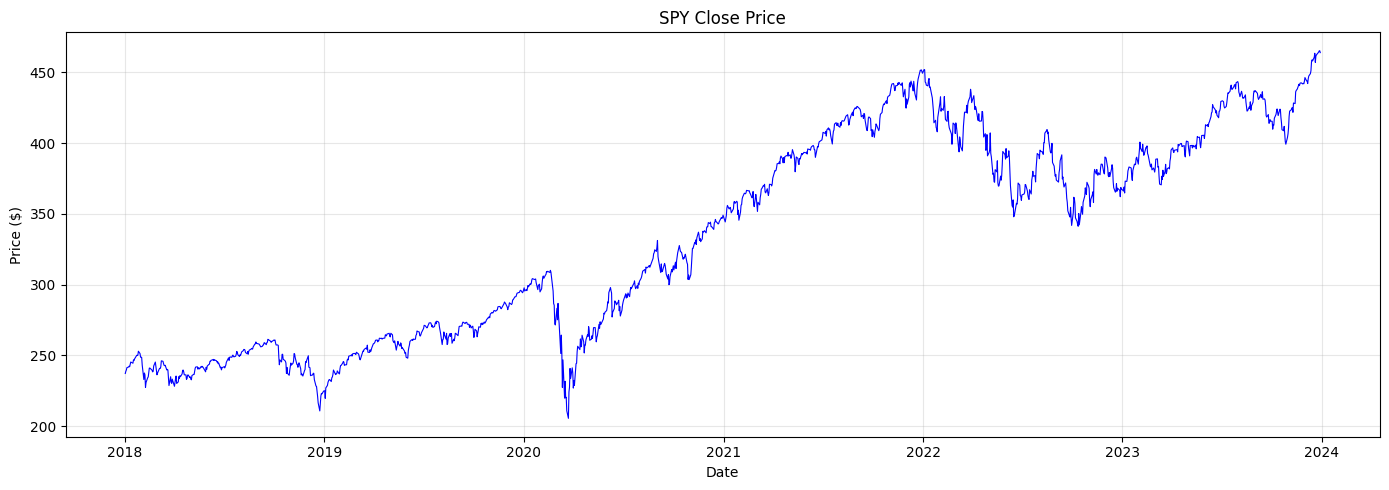

In [6]:
# Download stock data
print("Downloading SPY data...")
df = yf.download('SPY', start='2018-01-01', end='2024-01-01', progress=False)
prices = df['Close'].values.reshape(-1, 1)

print(f"Data shape: {prices.shape}")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")

# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(df.index, prices, 'b-', linewidth=0.8)
plt.title('SPY Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
def create_transformer_sequences(data, src_seq_len, tgt_seq_len):
    """
    Create source and target sequences for transformer
    
    Args:
        data: Normalized price data
        src_seq_len: Length of source (encoder input) sequence
        tgt_seq_len: Length of target (decoder output) sequence
    """
    src_sequences = []
    tgt_sequences = []
    
    total_len = src_seq_len + tgt_seq_len
    
    for i in range(len(data) - total_len + 1):
        src = data[i:i + src_seq_len]
        tgt = data[i + src_seq_len:i + total_len]
        src_sequences.append(src)
        tgt_sequences.append(tgt)
    
    return np.array(src_sequences), np.array(tgt_sequences)


# Normalize data
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Create sequences
SRC_SEQ_LEN = 30  # Look back 30 days
TGT_SEQ_LEN = 5   # Predict 5 days ahead

X, y = create_transformer_sequences(prices_scaled, SRC_SEQ_LEN, TGT_SEQ_LEN)
print(f"Source sequences shape: {X.shape}")
print(f"Target sequences shape: {y.shape}")

# Train/test split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Source sequences shape: (1475, 30, 1)
Target sequences shape: (1475, 5, 1)

Train set: 1180 samples
Test set: 295 samples


In [8]:
# Convert to PyTorch tensors and create DataLoaders
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test)

BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 37
Number of test batches: 10


---

## Part 7: Train the Transformer Model

In [9]:
# Initialize model
model = TimeSeriesTransformer(
    input_dim=1,
    d_model=64,
    n_heads=4,
    n_encoder_layers=2,
    n_decoder_layers=2,
    d_ff=256,
    dropout=0.1
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 233,793


In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for src, tgt in loader:
        src = src.to(device)
        tgt = tgt.to(device)
        
        # Teacher forcing: use shifted target as decoder input
        # Decoder input: start token + all but last target
        decoder_input = torch.cat([src[:, -1:, :], tgt[:, :-1, :]], dim=1)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, decoder_input)
        
        # Calculate loss
        loss = criterion(output, tgt)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def evaluate(model, loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for src, tgt in loader:
            src = src.to(device)
            tgt = tgt.to(device)
            
            decoder_input = torch.cat([src[:, -1:, :], tgt[:, :-1, :]], dim=1)
            output = model(src, decoder_input)
            loss = criterion(output, tgt)
            total_loss += loss.item()
    
    return total_loss / len(loader)


# Training loop
EPOCHS = 50
train_losses = []
test_losses = []
best_loss = float('inf')

print("Training Transformer...")
print("=" * 50)

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    scheduler.step(test_loss)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

# Load best model
model.load_state_dict(best_model_state)
print(f"\nBest test loss: {best_loss:.6f}")

Training Transformer...
Epoch  10/50 | Train Loss: 0.004666 | Test Loss: 0.001156
Epoch  20/50 | Train Loss: 0.002967 | Test Loss: 0.000978
Epoch  30/50 | Train Loss: 0.002431 | Test Loss: 0.001026
Epoch  40/50 | Train Loss: 0.002279 | Test Loss: 0.000783
Epoch  50/50 | Train Loss: 0.002008 | Test Loss: 0.001099

Best test loss: 0.000554


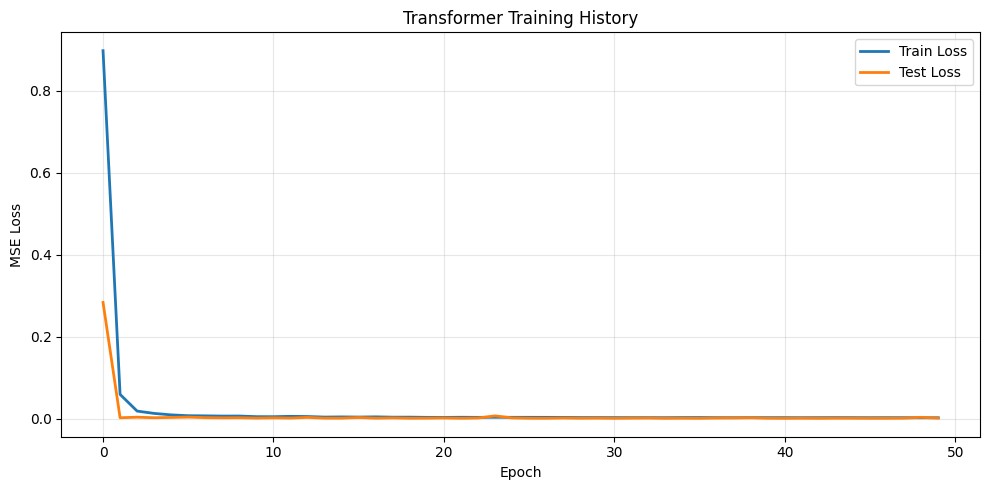

In [11]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Transformer Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Part 8: Generate Predictions (Autoregressive)

In [12]:
def autoregressive_predict(model, src, tgt_len, device):
    """
    Generate predictions autoregressively (one step at a time)
    This is how the model would be used in production
    """
    model.eval()
    
    with torch.no_grad():
        src = src.to(device)
        
        # Encode the source sequence
        encoder_output, _ = model.encode(src)
        
        # Start with the last value of source as first decoder input
        decoder_input = src[:, -1:, :]
        outputs = []
        
        for _ in range(tgt_len):
            # Generate causal mask
            tgt_mask = generate_causal_mask(decoder_input.size(1)).to(device)
            
            # Decode
            decoder_output = model.decode(decoder_input, encoder_output, tgt_mask=tgt_mask)
            
            # Get the last prediction
            pred = model.output_projection(decoder_output[:, -1:, :])
            outputs.append(pred)
            
            # Append prediction to decoder input for next step
            decoder_input = torch.cat([decoder_input, pred], dim=1)
        
        # Concatenate all predictions
        predictions = torch.cat(outputs, dim=1)
    
    return predictions


# Generate predictions for test set
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for src, tgt in test_loader:
        src = src.to(device)
        preds = autoregressive_predict(model, src, TGT_SEQ_LEN, device)
        all_predictions.append(preds.cpu().numpy())
        all_targets.append(tgt.numpy())

predictions = np.concatenate(all_predictions, axis=0)
targets = np.concatenate(all_targets, axis=0)

print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

Predictions shape: (295, 5, 1)
Targets shape: (295, 5, 1)


In [13]:
# Inverse transform predictions
predictions_flat = predictions.reshape(-1, 1)
targets_flat = targets.reshape(-1, 1)

predictions_inv = scaler.inverse_transform(predictions_flat).flatten()
targets_inv = scaler.inverse_transform(targets_flat).flatten()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(targets_inv, predictions_inv))
mae = mean_absolute_error(targets_inv, predictions_inv)
mape = np.mean(np.abs((targets_inv - predictions_inv) / targets_inv)) * 100

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"RMSE: ${rmse:.2f}")
print(f"MAE:  ${mae:.2f}")
print(f"MAPE: {mape:.2f}%")


MODEL PERFORMANCE METRICS
RMSE: $10.79
MAE:  $8.94
MAPE: 2.24%


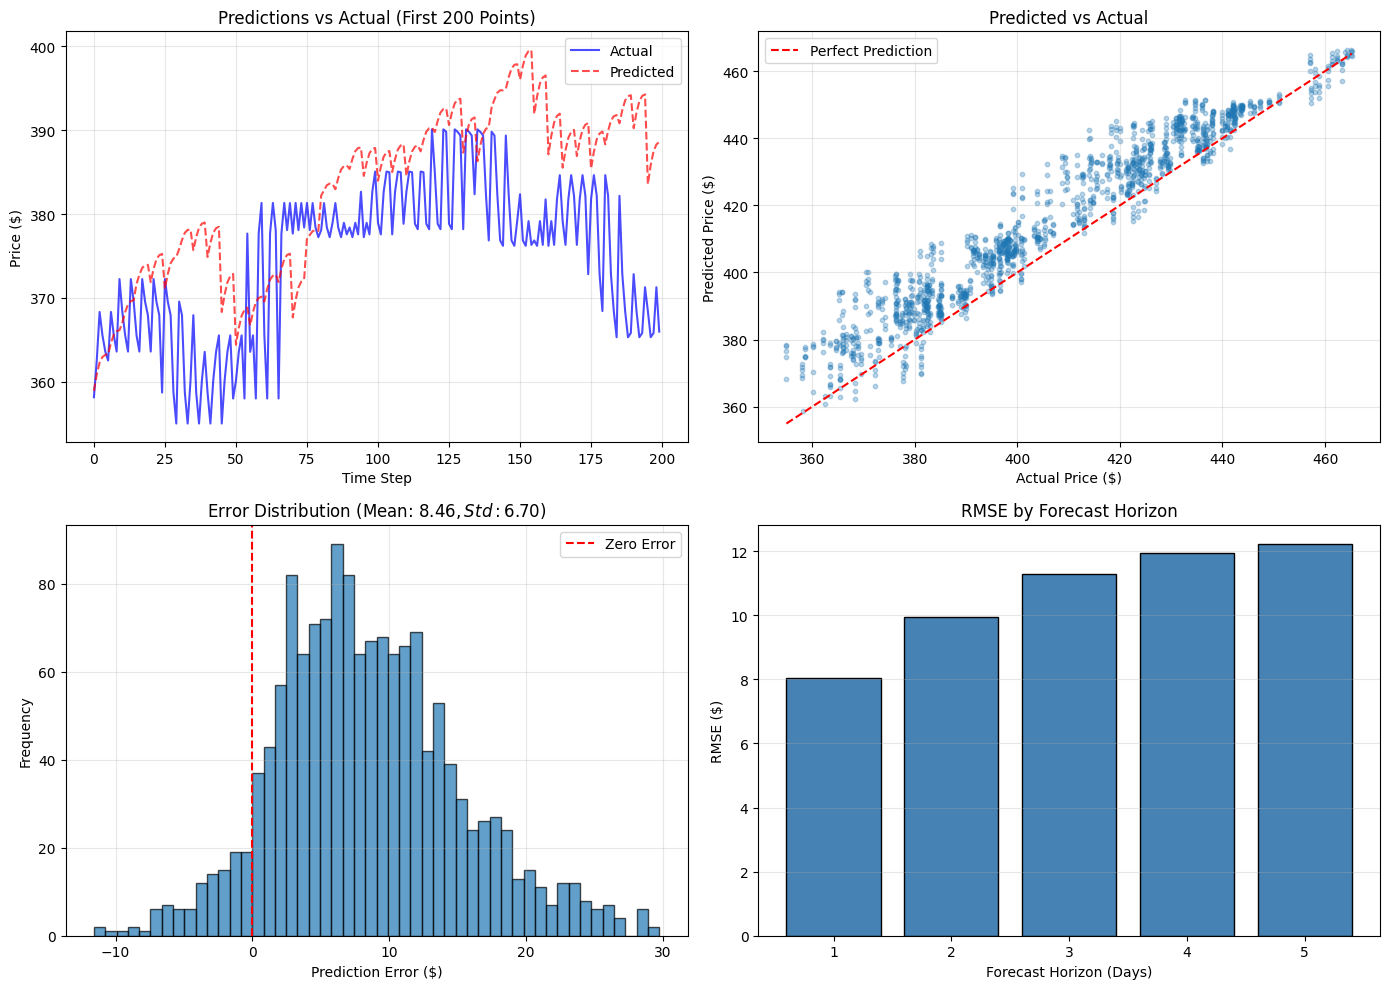

In [14]:
# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time series of predictions vs actual (first 200 points)
n_plot = 200
axes[0, 0].plot(targets_inv[:n_plot], 'b-', label='Actual', alpha=0.7)
axes[0, 0].plot(predictions_inv[:n_plot], 'r--', label='Predicted', alpha=0.7)
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].set_title('Predictions vs Actual (First 200 Points)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter plot
axes[0, 1].scatter(targets_inv, predictions_inv, alpha=0.3, s=10)
axes[0, 1].plot([targets_inv.min(), targets_inv.max()], 
                [targets_inv.min(), targets_inv.max()], 'r--', label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Price ($)')
axes[0, 1].set_ylabel('Predicted Price ($)')
axes[0, 1].set_title('Predicted vs Actual')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Prediction error distribution
errors = predictions_inv - targets_inv
axes[1, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', label='Zero Error')
axes[1, 0].set_xlabel('Prediction Error ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Error Distribution (Mean: ${errors.mean():.2f}, Std: ${errors.std():.2f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Rolling RMSE by horizon
horizon_rmse = []
for h in range(TGT_SEQ_LEN):
    h_preds = predictions[:, h, 0]
    h_targets = targets[:, h, 0]
    h_preds_inv = scaler.inverse_transform(h_preds.reshape(-1, 1)).flatten()
    h_targets_inv = scaler.inverse_transform(h_targets.reshape(-1, 1)).flatten()
    horizon_rmse.append(np.sqrt(mean_squared_error(h_targets_inv, h_preds_inv)))

axes[1, 1].bar(range(1, TGT_SEQ_LEN + 1), horizon_rmse, color='steelblue', edgecolor='black')
axes[1, 1].set_xlabel('Forecast Horizon (Days)')
axes[1, 1].set_ylabel('RMSE ($)')
axes[1, 1].set_title('RMSE by Forecast Horizon')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---

## Part 9: Visualize Attention Patterns

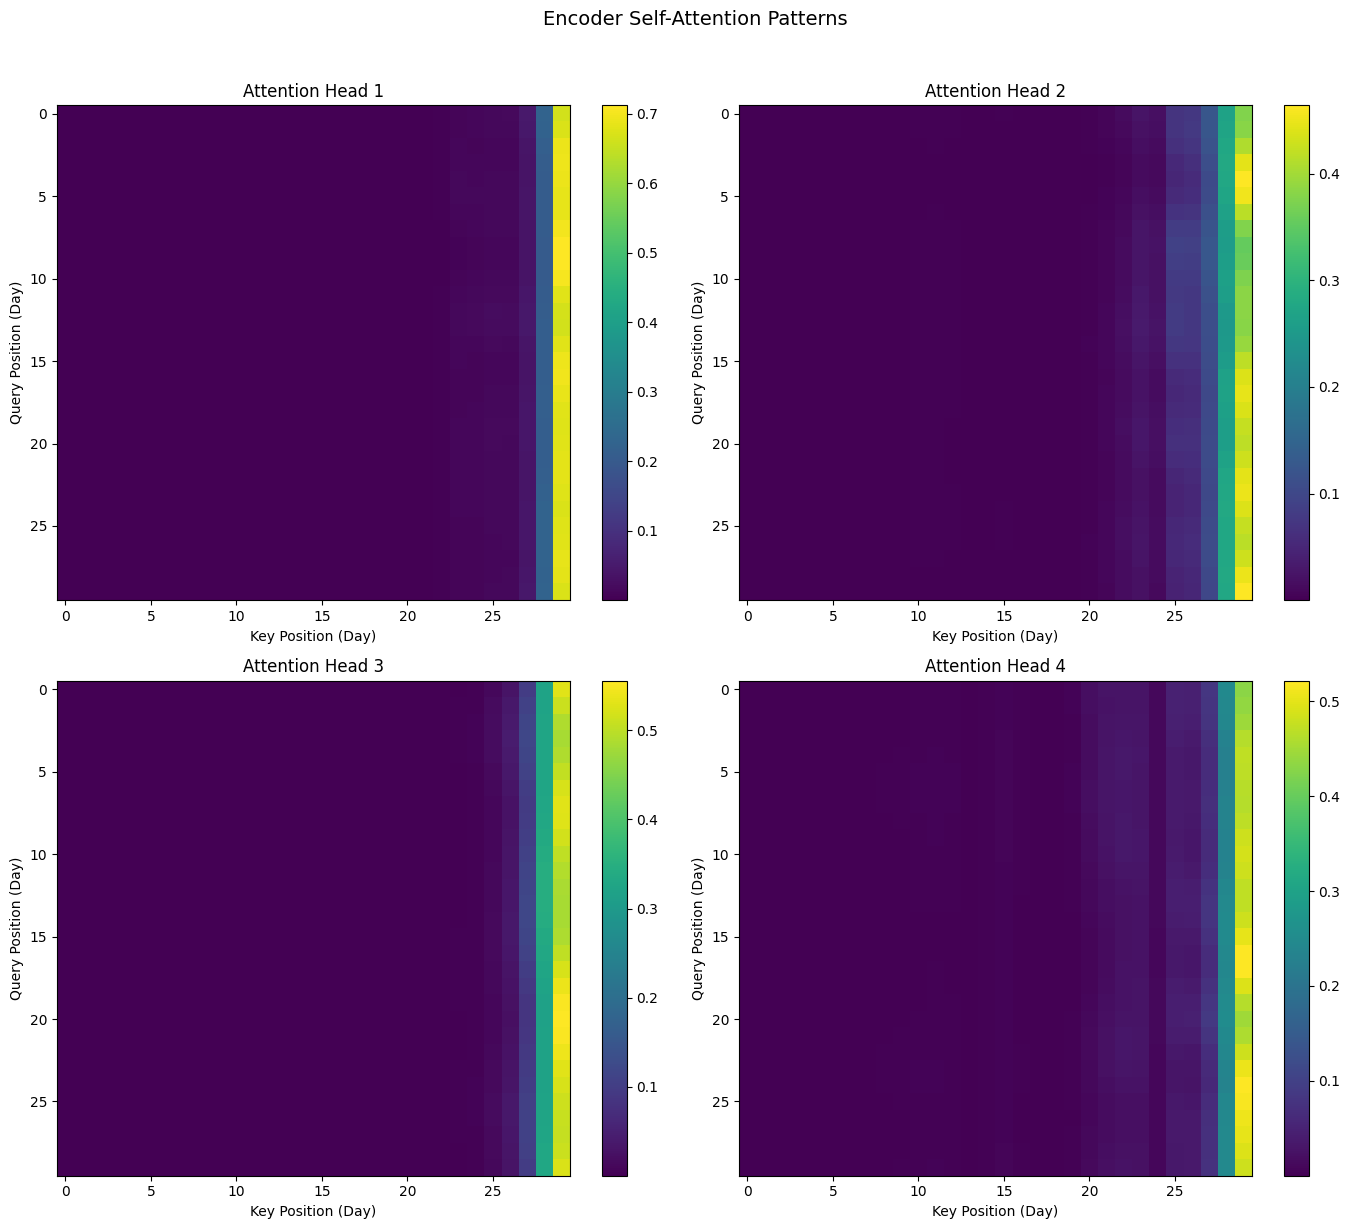

In [15]:
def get_attention_weights(model, src, device):
    """Extract attention weights from encoder"""
    model.eval()
    
    with torch.no_grad():
        src = src.to(device)
        _, attention_weights = model.encode(src)
    
    return attention_weights


# Get attention for a sample
sample_src = X_test_t[:1].to(device)
attention_weights = get_attention_weights(model, sample_src, device)

# Visualize attention from first encoder layer
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

attn = attention_weights[0][0].cpu().numpy()  # First layer, first sample

for i, ax in enumerate(axes.flatten()):
    if i < attn.shape[0]:  # Number of heads
        im = ax.imshow(attn[i], cmap='viridis', aspect='auto')
        ax.set_xlabel('Key Position (Day)')
        ax.set_ylabel('Query Position (Day)')
        ax.set_title(f'Attention Head {i+1}')
        plt.colorbar(im, ax=ax)

plt.suptitle('Encoder Self-Attention Patterns', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

## Part 10: Encoder-Only Transformer (Simpler Alternative)

For many time series tasks, an **encoder-only** architecture works well:
- Simpler to implement and train
- Works like a sequence classifier/regressor
- Often sufficient for prediction tasks

In [16]:
class EncoderOnlyTransformer(nn.Module):
    """
    Encoder-only Transformer for Time Series
    Simpler architecture for prediction tasks
    """
    def __init__(
        self,
        input_dim: int = 1,
        d_model: int = 64,
        n_heads: int = 4,
        n_layers: int = 3,
        d_ff: int = 256,
        max_seq_len: int = 500,
        dropout: float = 0.1,
        output_len: int = 1
    ):
        super().__init__()
        
        self.d_model = d_model
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len, dropout)
        
        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            EncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # Output head (predict from last position or pooled representation)
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, output_len)
        )
    
    def forward(self, x):
        """
        Args:
            x: Input sequence (batch_size, seq_len, input_dim)
        Returns:
            Prediction (batch_size, output_len)
        """
        # Project input
        x = self.input_projection(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        
        # Pass through encoder layers
        for encoder_layer in self.encoder_layers:
            x, _ = encoder_layer(x)
        
        # Use last position for prediction
        output = self.output_head(x[:, -1, :])
        
        return output


# Test encoder-only model
print("Testing Encoder-Only Transformer:")
encoder_model = EncoderOnlyTransformer(
    input_dim=1,
    d_model=64,
    n_heads=4,
    n_layers=3,
    output_len=TGT_SEQ_LEN
)

test_input = torch.randn(4, 30, 1)
output = encoder_model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Parameters: {sum(p.numel() for p in encoder_model.parameters()):,}")

Testing Encoder-Only Transformer:
Input shape: torch.Size([4, 30, 1])
Output shape: torch.Size([4, 5])
Parameters: 168,005


---

## Key Takeaways

### Transformer Architecture

| Component | Function |
|-----------|----------|
| **Positional Encoding** | Injects sequence position information |
| **Multi-Head Attention** | Captures multiple relationship patterns |
| **Encoder** | Processes input, builds representations |
| **Decoder** | Generates output autoregressively |
| **Residual Connections** | Enables training of deep networks |
| **Layer Normalization** | Stabilizes training |

### Advantages for Finance

1. **Parallel computation** - faster training than RNNs
2. **Long-range dependencies** - captures distant market relationships
3. **Interpretable attention** - visualize what the model focuses on
4. **Scalability** - handles large datasets efficiently

### Architecture Choices

- **Encoder-Decoder**: Multi-step forecasting, sequence-to-sequence
- **Encoder-Only**: Classification, single-step prediction
- **Decoder-Only**: Autoregressive generation (like GPT)

---

## Practice Exercises

1. **Add more features** - Include volume, returns, technical indicators
2. **Experiment with hyperparameters** - Try different d_model, n_heads, n_layers
3. **Compare architectures** - Test encoder-only vs encoder-decoder
4. **Learnable positional encoding** - Replace sinusoidal with learned embeddings
5. **Multi-asset prediction** - Predict multiple correlated assets simultaneously